In [36]:
import pandas as pd
import os
from bs4 import BeautifulSoup
from more_itertools import unique_everseen
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import matplotlib.cm as cm
import cv2 as cv 
from skimage import color
from skimage import feature
import random
from scipy.misc import imresize
from skimage.filters import rank
from skimage.morphology import square,disk
import cv2
from skimage.segmentation import slic
import warnings
from skimage.transform import rescale
%matplotlib inline
warnings.filterwarnings('ignore')

In [38]:
def load_images_from_folder(folder):
    images = {}
    filenames = []
    for filename in os.listdir(folder):
        filenames.append(filename[:-4])
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images[filename[:-4]]=[]
            images[filename[:-4]].append(img)
    return images,filenames
def luminance(image):
    n= image.shape[0]
    m= image.shape[1]
    image = image.reshape(n*m,3)
    for i in range(n*m):
        image[i][0] = np.abs(0.2125*image[i][0] + 0.7154*image[i][1] + 0.0721*image[i][2])
    image = np.delete(image,0,1)
    image = np.delete(image,0,1)
    image = image.reshape(n,m)
    return image
def get_mask_data(images,filenames):
    xml_data =[]
    mask_data={}
    mask_data2={}
    for a in images:
        file = bounding_box_dir + a + '.xml'
        xml =""
        with open(file) as f:
            xml = f.readlines()
            xml = ''.join([line.strip('\t') for line in xml])
            xml_new  = BeautifulSoup(xml,"lxml")
        xml_data.append(xml_new)
    for bd_data in xml_data:
        objs = bd_data.findAll('object')
        for obj in objs:
            obj_names = obj.findChildren('name')
            for name_tag in obj_names:
                fname = bd_data.findChild('filename').contents[0]
                blank_img = np.zeros((images[fname[:-4]][0].shape[0],images[fname[:-4]][0].shape[1]))
                bbox = obj.findChildren('bndbox')[0]
                xmin = int(bbox.findChildren('xmin')[0].contents[0])
                ymin = int(bbox.findChildren('ymin')[0].contents[0])
                xmax = int(bbox.findChildren('xmax')[0].contents[0])
                ymax = int(bbox.findChildren('ymax')[0].contents[0])
                blank_img[xmin:xmax,ymin:ymax] = 1
                if(fname[:-4] not in mask_data):
                    mask_data[fname[:-4]] =[]
                    mask_data2[fname[:-4]] =[]
                mask_data[fname[:-4]].append(blank_img)
                mask_data2[fname[:-4]].append([xmin,ymin,xmax,ymax])
    return mask_data,mask_data2
def show_mask_with_image(filename,images,mask_data2):
    masks = mask_data2[filename]
    image = images[filename][0].copy()
    for mask in masks:
        cv.rectangle(image,(mask[0],mask[1]),(mask[2],mask[3]),(0,0,255),2)
    plt.imshow(image)

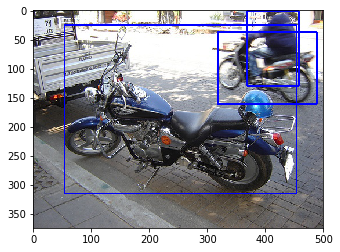

In [3]:
root_dir = '/home/ubuntu/College Assignments/DIP/Project/'
img_dir = os.path.join(root_dir, 'images/')
sample_img_dir = os.path.join(root_dir,'sample_images/')
bounding_box_dir = os.path.join(root_dir,'Boundingbox/')
images,filenames = load_images_from_folder(sample_img_dir) #list of images with each image with 3d and filenames of each image
mask_data,mask_data2 = get_mask_data(images,filenames) #mask_data - imgs with mask portion white and rest black and mask_data2 array of xmin,ymin,xmax,ymax
show_mask_with_image(filenames[20],images,mask_data2)

# Default Params

In [39]:
params={}
params['distribution_windows']=100000
params['min_width']=10
params['min_height']=10
params['min_window_width']=10
params['min_window_height']=10
params['pixelDistance']=8
params['imageBorder']=0.05
params['pascalThreshold'] = 0.5
params['ed'] ={}
params['ed']['pixelDistance']=8
params['ed']['imageBorder']=0
params['ed']['theta'] =20
params['MS'] = {}
params['MS']['scale'] = [16,24,32,48,64]
params['MS']['theta'] = [0.42,0.3,0.34,0.24,0.3]
params['MS']['filter_size'] = 3
params['CC'] = {}
params['CC']['domain'] = list(range(100,201,1))
params['CC']['quant'] = np.array([4,8,8])
params['CC']['theta'] = 100
params['SS'] = {}
params['SS']['sigma'] = 0.5
params['SS']['segments'] = 100

# Generate Windows

In [40]:
def generate_windows_uniform(img,params):
    height,width,_ = img.shape
    total_samples = params['distribution_windows']
    min_width = params['min_width']
    min_height = params['min_height']
    xmin = np.zeros((total_samples,1))
    xmax = np.zeros((total_samples,1))
    ymin = np.zeros((total_samples,1))
    ymax = np.zeros((total_samples,1))
    random.seed(100)
    for i in range(0,total_samples):
        x1 = round(random.random()*(width-1)+1)
        x2 = round(random.random()*(width-1)+1)
        while(abs(x1-x2)+1<min_width):
            x1=round(random.random()*(width-1)+1)
            x2=round(random.random()*(width-1)+1)        
        y1 = round(random.random()*(height-1)+1)
        y2 = round(random.random()*(height-1)+1)
        while(abs(y1-y2)+1<min_height):
            y1=round(random.random()*(height-1)+1)
            y2=round(random.random()*(height-1)+1)
        xmin[i]=min(x1,x2)
        ymin[i]=min(y1,y2)
        xmax[i]=max(x1,x2)
        ymax[i]=max(y1,y2)
    windows = [xmin,ymin,xmax,ymax]
    return np.asarray(windows)        

In [41]:
def generate_windows_dense(img,params):
    pixelDistance = params['ed']['pixelDistance']
    imageBorder = params['ed']['imageBorder']
    if(len(img.shape)==3):
        height,width,channels = img.shape
    else:
        height,width = img.shape
    offsetHeight = np.floor(imageBorder * height)
    offsetWidth  = np.floor(imageBorder * width)
    height = int(np.floor(height * (1 - imageBorder)/pixelDistance))
    width  = int(np.floor(width  * (1 - imageBorder)/pixelDistance))
    totalWindows = int(height*width * (height+1) * (width+1)/4)    
    xmin = np.zeros((totalWindows,1))
    xmax = np.zeros((totalWindows,1))
    ymin = np.zeros((totalWindows,1))
    ymax = np.zeros((totalWindows,1))
    currentWindow = 0
    for x in range(1,width+1):
        for y in range(1,height+1):
            for w in range(1,width - x+2 ):
                for h in range(1,height - y+2):                    
                    xmin[currentWindow] = x
                    ymin[currentWindow] = y
                    xmax[currentWindow] = x + w - 1
                    ymax[currentWindow] = y + h - 1
                    currentWindow = currentWindow+1
    xmin = xmin * pixelDistance + offsetWidth
    xmax = xmax * pixelDistance + offsetWidth
    ymin = ymin * pixelDistance + offsetHeight
    ymax = ymax * pixelDistance + offsetHeight
    windows = [xmin,ymin,xmax,ymax]
    return windows

In [42]:
img = images[filenames[0]][0]
windows = generate_windows_uniform(img,params)
print(np.asarray(windows).shape)

(4, 100000, 1)


In [43]:
img = images[filenames[0]][0]
windows = generate_windows_dense(img,params)
print(np.asarray(windows).shape)

(4, 2111193, 1)


# Edge Density Score

In [53]:
def compute_scores(image,xmin,ymin,xmax,ymax):
    windows[windows==0] = 1
    score = np.zeros(len(xmin))
    for i in range(len(xmin)):
        score[i] = image[ymax[i][0]][xmax[i][0]]+image[ymin[i][0]][xmin[i][0]]-image[ymin[i][0]][xmax[i][0]] - image[ymax[i][0]][xmin[i][0]]
    return score
def compute_integral_image(image):  
    image = np.cumsum(image,axis=0)
    image = np.cumsum(image,axis=1)
    pad_image = np.zeros((image.shape[0]+1,image.shape[1]+1))
    pad_image = image[1:,1:]
    return pad_image
def edge_density_score(image,params):
    channels = image.shape[2]
    theta = params['ed']['theta']    
    if channels==3:
        image = luminance(image)
    edge_image = feature.canny(image)
    integral_image = compute_integral_image(edge_image)
    windows = generate_windows_dense(integral_image,params=params)
    xmin = (windows[0]).astype(int)
    ymin = (windows[1]).astype(int)
    xmax = (windows[2]).astype(int)
    ymax = (windows[3]).astype(int)
    xmax_inner = (np.round((xmax*(200+theta)/(theta+100) + xmin*theta/(theta+100)+100/(theta+100)-1)/2)).astype(int)
    xmin_inner = (np.round(xmax+xmin-xmax_inner)).astype(int)
    ymax_inner = (np.round((ymax*(200+theta)/(theta+100) + ymin*theta/(theta+100)+100/(theta+100)-1)/2)).astype(int)
    ymin_inner = (np.round(ymax+ymin-ymax_inner)).astype(int)
    score_windows = compute_scores(integral_image,xmin,ymin,xmax,ymax)
    score_inner_windows = compute_scores(integral_image,xmin_inner,ymin_inner,xmax_inner,ymax_inner)
    area_windows = (xmax-xmin+1) * (ymax-ymin+1)
    area_inner_windows = (xmax_inner - xmin_inner +1) * (ymax_inner -ymin_inner +1)
    area_diff = area_windows - area_inner_windows
    area_diff[area_diff==0] = 100000000   
    score = np.zeros((len(xmax),1))
    for i in range(len(score)):
        score[i] = ((xmax[i]-xmax_inner[i]+ymax[i]-ymax_inner[i])*(score_windows[i]-score_inner_windows[i])/area_diff[i])
    boxes = [windows,score]
    return boxes

# Multi Scale Saliency

In [54]:
def saliency_map_channel(img,channel,params,scale):
    filter_size = params['MS']['filter_size']
    img = 1.00*img[:,:,channel]
    resized_img = imresize(img,(scale,scale),interp='bilinear')
    f = np.fft.fft2(resized_img)
    filter1 = square(filter_size)
    filter2 = disk(filter_size)
    log_amplitude = np.log(np.absolute(f))/255
    phase = np.angle(f)
    smooth = rank.mean(log_amplitude, selem=filter1)
    spectral_residual = log_amplitude - smooth
    saliency_map = np.absolute(np.fft.ifft(np.exp(spectral_residual +1+ phase)))**2
    saliency_map = rank.mean(saliency_map, selem=filter2)
    return saliency_map    
def sliding_window_compute_score(saliency_map,scale,min_width,min_height,threshold,sal_integral_image,thr_integral_image):
    score_scale = []   
    image_area = scale*scale
    i=0
    for xmin in range(0,scale-min_width):
        for ymin in range(0,scale-min_height):
            for xmax in range(xmin+min_width,scale):
                for ymax in range(ymin+min_height,scale):
                    area = (xmax-xmin)*(ymax-ymin)
                    aval = sal_integral_image[ymin][xmin]+sal_integral_image[ymax][xmax]-sal_integral_image[ymax][xmin]-sal_integral_image[ymin][xmax]
                    athr = thr_integral_image[ymin][xmin]+thr_integral_image[ymax][xmax]-thr_integral_image[ymax][xmin]-thr_integral_image[ymin][xmax]
                    windows = [xmin,ymin,xmax,ymax]
                    score_scale.append([windows,aval*athr/area])                                     
    return score_scale
def retrieve_coordinates(index,scale):
    image_area = scale*scale
    index1 = index%image_area
    index2 = np.floor(index/image_area)
    x1 = index1%scale + 1
    y1 = np.floor(index1/scale)+1
    x2 = index2%scale + 1
    y1 = np.floor(index2/scale)+1
    return x1,y1,x2,y2   
def compute_integral_image(image):  
    image = np.cumsum(image,axis=0)
    image = np.cumsum(image,axis=1)
    pad_image = np.zeros((image.shape[0]+1,image.shape[1]+1))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pad_image[i+1][j+1] = image[i][j]
    return pad_image
def MS_score(img,params):
    xmin = [];ymin = [];xmax = [];ymax = [];score = []
    height,width,channels = img.shape
    scales = params['MS']['scale']
    theta = params['MS']['theta']
    min_window_height = params['min_window_height'] 
    min_window_width = params['min_window_width']
    distribution_windows = params['distribution_windows']
    filter_size = params['MS']['filter_size']
    xmins=[]
    xmaxs =[]
    ymins=[]
    ymaxs=[]
    scores =[]
    for i in range(len(scales)):
        scale = scales[i]
        threshold = theta[i]
        min_width = int(max(2,np.round(min_window_width*scale/width )))
        min_height = int(max(2,np.round(min_window_height*scale/height)))
        samples = np.round(distribution_windows/(len(scales)*3))
        for j in range(channels):
            saliency_map = saliency_map_channel(img,j,params,scale)
            thr_map = saliency_map >=threshold
            sal_map = np.multiply(saliency_map,thr_map)
            thr_integral_image = compute_integral_image(thr_map)
            sal_integral_image = compute_integral_image(sal_map)
            score_scale = sliding_window_compute_score(saliency_map,scale,min_width,min_height,threshold,sal_integral_image,thr_integral_image)
            index_positives = np.argwhere(np.asarray(score_scale).T[1]>0)
            for i in range(len(index_positives)):
                xmin = int(score_scale[index_positives[i][0]][0][0]*width/scale)
                ymin = int(score_scale[index_positives[i][0]][0][1]*height/scale)
                xmax = int(score_scale[index_positives[i][0]][0][2]*width/scale)
                ymax = int(score_scale[index_positives[i][0]][0][3]*height/scale)
                xmins.append(xmin) 
                ymins.append(ymin)  
                xmaxs.append(xmax)  
                ymaxs.append(ymax)  
                scores.append(score_scale[index_positives[i][0]][1])                
    boxes = [[np.asarray(xmins),np.asarray(ymins),np.asarray(xmaxs),np.asarray(ymaxs)],np.asarray(scores)]
    return boxes   

# Color Contrast Score

In [55]:
def computeContrastScore(Q,windows,theta):    
    height,width= Q.shape
    surrBox = np.copy(windows)
    contrast = np.zeros(((windows.shape[1]),1))
    Q2 = np.copy(Q)
    for w in range(0,windows.shape[1]):
        xmin = int(windows[0][w])
        ymin = int(windows[1][w])
        xmax = int(windows[2][w])
        ymax = int(windows[3][w])        
        num_pixels_inner = abs((xmin-xmax+1)*(ymin-ymax+1))        
        mask_inner = np.zeros((height,width),dtype='uint8')
        mask_inner[ymin:ymax, xmin:xmax]= 255        
        #plt.imshow(mask_inner)
        H_inner = cv2.calcHist([Q],[0],mask_inner,histSize=[256],ranges=[0,256])        
        offsetWidth=width*theta/200;
        offsetHeight=height*theta/200;
        xminSurr=round(max(xmin-offsetWidth,0))
        xmaxSurr=round(min(xmax+offsetWidth,width))
        yminSurr=round(max(ymin-offsetHeight,0))
        ymaxSurr=round(min(ymax+offsetHeight,height))        
        a = Q[yminSurr:ymaxSurr,xminSurr:xmin].flatten()
        b = Q[yminSurr:ymaxSurr,xmax:xmaxSurr].flatten()
        c = Q[yminSurr:ymin,xmin:xmax].flatten()
        d = Q[ymax:ymaxSurr,xmin:xmax].flatten()        
        outer_r = np.hstack((a,b,c,d))        
        num_pixels_outer = len(outer_r)        
#         mask_outer = np.zeros((height,width),dtype='uint8')
#         mask_outer[yminSurr:ymaxSurr, xminSurr:xmaxSurr]= 255        
        H_outer = cv2.calcHist([outer_r],[0],None,histSize=[256],ranges=[0,256])        
        H_inner2 = np.asarray(H_inner/num_pixels_inner,dtype='float32')
        H_outer2 = np.asarray(H_outer/num_pixels_outer,dtype='float32')        
        Q2 = cv2.rectangle(Q2,(xminSurr,yminSurr),(xmaxSurr,ymaxSurr),(0,255,0),2)
        Q2 = cv2.rectangle(Q2,(xmin,ymin),(xmax,ymax),(255,0,0),2)        
        contrast[w] = cv2.compareHist(H_inner2, H_outer2, 1)      
    #plt.imshow(Q2)    
    return contrast
def computeQuantMatrix(imgLAB,bins):
    L = imgLAB[:,:,0]
    a = imgLAB[:,:,1]
    b = imgLAB[:,:,2]    
    ll = np.minimum(np.floor(L/(100/bins[0])) + 1,bins[0])    
    aa = np.minimum(np.floor((a+120)/(240/bins[1])) + 1,bins[1])
    bb = np.minimum(np.floor((b+120)/(240/bins[2])) + 1,bins[2])
    Q = (ll-1)* bins[1]*bins[2] + (aa - 1)*bins[2] + bb
    return np.asarray(Q,dtype='uint8')
def CC_score(image,params):
    height, width, _ = image.shape
    windows = np.asarray(generate_windows_dense(image,params=params))
    theta = params['CC']['theta']
    totalWindows = len(windows)
    imgLab = color.rgb2lab(image)
    quant = params['CC']['quant']
    Q = computeQuantMatrix(imgLab,quant)
    score = computeContrastScore(Q,windows,theta)    
    boxes = [windows,score]
    return boxes

# Super Pixel Score

In [62]:
def segmentArea(S):
    tot_seg = np.max(S)
    seg = {}
    for i in range(0,tot_seg):
        seg[i] = {}
        seg[i]['cord'] = np.column_stack(np.where(S==i))
        seg[i]['area'] = len(seg[i]['cord'])
    return seg
def integrateSuperPixels(N):
    tot_seg = np.max(N)
    height, width = N.shape
    integralHist = np.zeros((height+1,width+1,tot_seg))
    for i in range(0,tot_seg):
        superPixelMap = (N-i)==0
        integralHist[:,:,i] = computeIntegralImage(superPixelMap)
    return integralHist
def computeIntegralImage(I):
    integralImage = np.cumsum(I,axis=0)
    integralImage = np.cumsum(integralImage,axis=1)
    npad = ((1, 0), (1,0))
    integralImage = np.pad(integralImage, pad_width=npad, mode='constant', constant_values=0)
    return integralImage
def computeIntegralImageScores(integralImage,windows):
    windows = np.asarray(windows,dtype='int64')
    windows[windows == 0] = 1
    height = integralImage.shape[0]
    index1 = height*windows[2] + (windows[3] + 1)
    index2 = height*(windows[0] - 1) + windows[1]
    index3 = height*(windows[0] - 1) + (windows[3] + 1)
    index4 = height*windows[2] + windows[1]    
    integralImageFlat = integralImage.flatten()
    score = integralImageFlat[index1] + integralImageFlat[index2] - integralImageFlat[index3] - integralImageFlat[index4]
    return score
def SSS_score(image,params):
    windows = np.asarray(generate_windows_dense(img,params))
    num_segments = params['SS']['segments']
    sgma = params['SS']['sigma']
    segments = slic(image, n_segments = num_segments, sigma = sgma)
    integrateHist = integrateSuperPixels(segments)
    superPixels = segmentArea(segments)
    xmin = (windows[0])
    ymin = (windows[1])
    xmax = (windows[2])
    ymax = (windows[3])
    areaSuperPixels=[]
    for i in range(0,len(superPixels)):
        areaSuperPixels.append(superPixels[i]['area'])
    areaWindows = (xmax - xmin + 1) * (ymax - ymin + 1)
    areaWindows=np.asarray(areaWindows).reshape(-1)
    _,_,n = integrateHist.shape
    intersectionSuperpixels = np.zeros((len(xmin),n))
    for i in range(0,n):
        scores = computeIntegralImageScores(integrateHist[:,:,i],windows) 
        intersectionSuperpixels[:,i] = scores.T
    score = np.ones((windows.shape[1])) - (np.sum(np.minimum(intersectionSuperpixels,np.tile(areaSuperPixels,(windows.shape[1],1)) - intersectionSuperpixels),axis=1)/areaWindows);
    boxes = [windows,score]
    return boxes

# Sampling

In [63]:
def nms_sample(boxes,threshold):
    xmin = boxes[0][0]
    ymin = boxes[0][1]
    xmax = boxes[0][2]
    ymax = boxes[0][3] 
    scores = (boxes[1]).reshape(len(boxes[1]),)
    #print(xmin.shape,xmax.shape)
    area = (xmax-xmin+1) * (ymax-ymin+1)
    indices = np.argsort(scores)
    pick=[]
    s_list=[]
    while(len(indices)>0):
        last = len(indices)-1
        i = indices[last]        
        pick.append(i)
        supress = [last]
        s_list.append(last)
        for pos in range(0,last):
            j = indices[pos]            
            xx1 = max(xmin[i],xmin[j])
            yy1 = max(ymin[i],ymin[j])
            xx2 = min(xmax[i],xmax[j])
            yy2 = min(ymax[i],ymax[j])            
            w = max(0,xx2-xx1+1)
            h = max(0,yy2-yy1+1)
            b1 = [xmin[i],ymin[i],xmax[i],ymax[i]]
            b2 = [xmin[j],ymin[j],xmax[j],ymax[j]]
            overlap = computePascalScore(b1,b2)
            #overlap = float(w*h)/area[j]
            #print(overlap)
            if(overlap>=threshold):
                supress.append(pos)
                s_list.append(pos)
        indices = np.delete(indices,supress)
    #print((pick))
    xmin_final=xmin[pick]
    ymin_final=ymin[pick]
    xmax_final=xmax[pick]
    ymax_final=ymax[pick]    
    boxes_final = [xmin_final,ymin_final,xmax_final,ymax_final]
    return np.asarray(boxes_final),pick,scores

In [64]:
def computePascalScore(box1,box2):
    intersection_area = computeIntersectionArea(box1,box2)
    pascalScore = intersection_area/(computeArea(box1)+computeArea(box2)-intersection_area)
    return pascalScore
def computeArea(box):    
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    if(xmin>xmax or ymin>ymax):
        area = 0
    else:
        area = (xmax-xmin+1)*(ymax-ymin+1)
    return area
def computeIntersectionArea(box1,box2):
    xmin = max(box1[0],box2[0])
    ymin = max(box1[1],box2[1])
    xmax = max(box1[2],box2[2])
    ymax = max(box1[3],box2[3]) 
    intersection_box = np.asarray([xmin,ymin,xmax,ymax]).reshape((4,1))
    intersection_area = computeArea(intersection_box)
    return intersection_area

In [65]:
def runObjectness(img,params,maxWindows=10):
    resized_img = imresize(img,(200,200),interp='bilinear')
    distribution_boxes_edge = edge_density_score(resized_img,params)
    distribution_boxes_MS = MS_score(img,params)
    distribution_boxes_CC = CC_score(img,params)
    distribution_boxes_SSS = SSS_score(img,params)
    boxes_edge = nms_sample(distribution_boxes_edge,0.5)
    boxes_MS = nms_sample(distribution_boxes_MS,0.5)
    boxes_CC = nms_sample(distribution_boxes_CC,0.5)
    boxes_SSS = nms_sample(distribution_boxes_SSS,0.5)
    return boxes_MS,boxes_edge,boxes_CC,boxes_SSS

In [66]:
def drawboxes(img,boxes):
    xmin = boxes[0][0].flatten()
    ymin = boxes[0][1].flatten()
    xmax = boxes[0][2].flatten()
    ymax = boxes[0][3].flatten()
    box_img = np.copy(img)
    for i in range(0,len(xmin)):
        box_img = cv2.rectangle(box_img,(int(xmin[i]),int(ymin[i])),(int(xmax[i]),int(ymax[i])),[255,0,0],2)
    plt.imshow(box_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


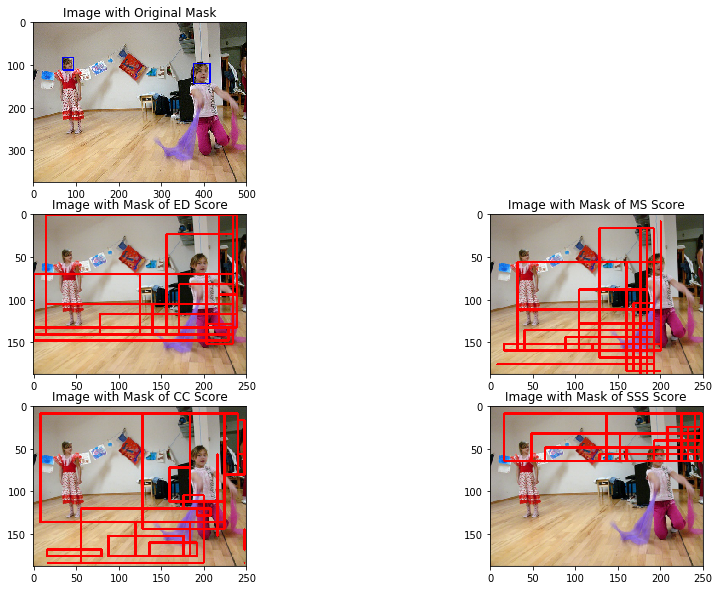

In [67]:
img = images[filenames[45]][0]
img = rescale(img, 1.0 / 2.0, anti_aliasing=True)
boxes1,boxes2,boxes3,boxes4 = runObjectness(img,params,10)
plt.figure(figsize=(15,10))
plt.subplot(3,2,1)
plt.title('Image with Original Mask')
show_mask_with_image(filenames[45],images,mask_data2)
plt.subplot(3,2,3)
plt.title('Image with Mask of ED Score')
drawboxes(img,boxes1)
plt.subplot(3,2,4)
plt.title('Image with Mask of MS Score')
drawboxes(img,boxes2)
plt.subplot(3,2,5)
plt.title('Image with Mask of CC Score')
drawboxes(img,boxes3)
plt.subplot(3,2,6)
plt.title('Image with Mask of SSS Score')
drawboxes(img,boxes4)